In [4]:
"""
*Filename: ThePlayground:
*Description: In this jupyter notebook models the weights of trained deepset neural networks
*are loaded into copies of their respective neural network architectures for the purposes of
*further exploration and testing beyond the initial checks that the network converged to a solution. 
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""
#Import the relevant models:
import awkward as ak
import os
import numpy as np
import uproot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from numpy.lib.recfunctions import structured_to_unstructured
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.ensemble import RandomForestRegressor
import DeepSetNeuralNetArchitecture as DSNNA
from HffragDeepSetsProjectionMultivariate import DeepSetsProjection
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))
/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'red'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [39]:
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/ResidualDeepSetsUpdatedWeights&Biases2.ckpt"
checkpoint = os.path.dirname(path)
latest_DeepNet = tf.train.latest_checkpoint(checkpoint)

In [7]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("/storage/epp2/phswmv/data/hffrag/hffrag.root:CharmAnalysis")

In [8]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000  # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 2e5 #This is the maximum number of events that will the program will accept
LR = 1e-4 #This is the default learning rate

In [9]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
SV_features = ["TruthParticles_Selected_LxyT"]

In [10]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features + SV_features, entry_stop=MAXEVENTS)

In [11]:
#Select the events of interest
events = features[ak.sum(features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis = 1) > 0]

In [12]:
# Displays the number of jets being trained on
jets = events[jet_features][:,0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

# Select tracks from the events
tracks = events[track_features]
Secondary_Displacement_temp_first = events[SV_features]

# Match the tracks to the jets
mask = DSNNA.Match_Tracks(jets, tracks)
matchedtracks = tracks[mask]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
Secondary_Displacement_temp_a = DSNNA.flatten(Secondary_Displacement_temp_first, 6).to_numpy()
Secondary_Displacement_temp_b = Secondary_Displacement_temp_a[:,0]
Secondary_Displacement_temp = Secondary_Displacement_temp_b[bjets]
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads_m = jets["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()
bhads_PGID = jets["AnalysisAntiKt4TruthJets_ghostB_pdgId"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
jets_m = jets["AnalysisAntiKt4TruthJets_m"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi, jets_m], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi, bhads_m],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's predictions

The number of jets to train on is:  199840
The number of track features is:  8
There are 4 outputs
There are 32 inputs


In [13]:
Secondary_Displacement = np.array([x[0] for x in Secondary_Displacement_temp])
print(np.min(Secondary_Displacement), np.max(Secondary_Displacement))

-999.0 115.98360443115234


In [14]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-5]])
matchedtracks = structured_to_unstructured(matchedtracks)

In [15]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
polartracks = matchedtracks.to_numpy()
Num_events = MAXTRACKS
tracks_pt = polartracks[:,:,0].reshape(-1,Num_events,1)
tracks_eta = polartracks[:,:,1].reshape(-1,Num_events,1)
tracks_phi = polartracks[:,:,2].reshape(-1,Num_events,1)

tracks_pep = np.concatenate([tracks_pt,tracks_eta,tracks_phi], axis = -1) 
print(tracks_pep.shape)

jets_pt = b_jets[:,0].reshape(-1,1)
jets_eta = b_jets[:,1].reshape(-1,1)
jets_phi = b_jets[:,2].reshape(-1,1)

b_jets_pep = np.concatenate([jets_pt,jets_eta,jets_phi], axis = -1) 
print(b_jets_pep.shape)

tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
b_jets_m = b_jets[:,-1].reshape(-1,1)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,tracks_pep,matchedtracks[:,:,3:].to_numpy()],axis = 2)
b_jets = np.concatenate([b_jets_p,b_jets_pep,b_jets_m] ,axis = 1)

(96659, 32, 3)
(96659, 3)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:108: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [22]:
tracks = np.ma.masked_values(tracks,-999)
bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
bhads_fractions_pt = bhads_pt/b_jets_pep[:,0]
print(bhads_fractions_px.shape)

(93323,)


In [17]:
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_fractions = np.stack([bhads_fractions_px,bhads_fractions_py, bhads_fractions_pz], axis = -1)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(bhads_fractions.shape)

Tracks_Momentum = np.sqrt(tracks[:, : ,0]**2 + tracks[:,:,1]**2 + tracks[:,:,2]**2)
Tracks_4_Momentum = np.stack([Tracks_Momentum, tracks[:,:,0], tracks[:,:,1], tracks[:,:,2]], axis = -1)
print(Tracks_4_Momentum.shape)

Tracks_Invariant_Mass = np.sqrt((np.sum(Tracks_4_Momentum, axis = 1) * np.sum(Tracks_4_Momentum, axis = 1)).sum(axis = -1))
print(Tracks_Invariant_Mass.shape)

(96659, 3)


/tmp/ipykernel_15126/2222755888.py:6: RuntimeWarning: invalid value encountered in sqrt
  Tracks_Momentum = np.sqrt(tracks[:, : ,0]**2 + tracks[:,:,1]**2 + tracks[:,:,2]**2)


(96659, 32, 4)
(96659,)


In [18]:
#Identify the outliers in the dataset and remove them to prevent spikes during learning.
print(np.max(bhads_fractions_px), np.min(bhads_fractions_px))
print(np.max(bhads_fractions_py), np.min(bhads_fractions_py))
print(np.max(bhads_fractions_pz), np.min(bhads_fractions_pz))
print(np.min(bhads_fractions_pt), np.min(bhads_fractions_pt))
array = [x for x in range(bhads_fractions_px.shape[0])]

#Remove the outliers in the dataset with momenta fractions and projections that are either unphysical or statistically unlikely
bhads_trial = np.stack([array,bhads_fractions_px, bhads_fractions_py, bhads_fractions_pz, bhads_projection, Secondary_Displacement], axis = -1)
bhads_fractions_clean  = bhads_trial[(bhads_trial[:,1] <= 10) & (bhads_trial[:,1] >= -10) & (bhads_trial[:,2] <= 10) & (bhads_trial[:,2] >= -10) & (bhads_trial[:,3] <= 10) & (bhads_trial[:,3] >= -10) & (bhads_trial[:,4] >= -10) & (bhads_trial[:,4] <= 10) & (bhads_trial[:,5] >= -10) * (bhads_trial[:,5] <= 10)]
print(bhads_fractions_clean.shape)

#Compare to the original range of the momenta fractions
print(np.max(bhads_fractions_clean[:,1]), np.min(bhads_fractions_clean[:,1]))
indices = bhads_fractions_clean[:,0]
print(indices.shape)

618.1237235802715 -4195.466731248074
81.60295597226761 -34465.39587820514
286.70118793549557 -709.6182655719883
0.008578880941776086 0.008578880941776086
(93323, 6)
9.82205875847657 -9.818688888748579
(93323,)


In [19]:
#Find the indices of the remaining datapoints
indices = [int(x) for x in indices]
print(np.shape(indices))

(93323,)


In [20]:
tracks = tracks[indices]
b_jets = b_jets[indices]
bhads = bhads[indices]
bhads_pt = bhads_pt[indices]
bhads_eta = bhads_eta[indices]
bhads_phi = bhads_phi[indices]
bhads_PGID = bhads_PGID[indices]
b_jets_m = b_jets_m[indices]
b_jets_pep = b_jets_pep[indices]
bhads_m = bhads_m[indices]
Secondary_Displacement = Secondary_Displacement[indices]

In [23]:
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_mag = np.linalg.norm(bhads[:,:3], axis = 1)
tracks_Momentum = np.sum(np.linalg.norm(tracks[:,:,:3], axis = 2))

bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
print(bhads_fractions_px.shape)

b_jets_energy = np.sqrt((b_jets_m[:,0]**2) + (b_jets_mag**2))
print(b_jets_energy.shape, b_jets_m.shape)

b_jets_energy_pt = np.sqrt((b_jets_m[:,0]**2) + (b_jets[:,4]**2))
b_jets_energy_pt.shape

b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]

print(b_jet_energy_mass_ratio.shape)
bhads_energy = np.sqrt((bhads_m**2) + (bhads_mag**2))
bhads_energy.shape

bhads_energy_mass_ratio = bhads_energy/bhads_m

print(bhads_fractions[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions),np.max(bhads_fractions))

print(bhads_fractions_px[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions_px),np.max(bhads_fractions_px))

print("Hello")
sum_px_tracks = np.sum(tracks[:,:,0], axis = 1)
sum_py_tracks = np.sum(tracks[:,:,1], axis = 1)
sum_pz_tracks = np.sum(tracks[:,:,2], axis = 1)
sum_pt_tracks = np.sum(tracks[:,:,3], axis = 1)
print(sum_pt_tracks.shape)

sum_px_tracks_RSE = np.sqrt(np.sum(tracks[:,:,0]**2, axis = 1))
sum_py_tracks_RSE= np.sqrt(np.sum(tracks[:,:,1]**2, axis = 1))
sum_pz_tracks_RSE = np.sqrt(np.sum(tracks[:,:,2]**2, axis = 1))
sum_pt_tracks_RSE = np.sqrt(np.sum(tracks[:,:,3]**2, axis = 1))
print(sum_pt_tracks_RSE.shape)

RSM_scaled_px = sum_px_tracks_RSE/sum_px_tracks
RSM_scaled_py = sum_py_tracks_RSE/sum_py_tracks
RSM_scaled_pz = sum_pz_tracks_RSE/sum_pz_tracks
RSM_scaled_pt = sum_pt_tracks_RSE/sum_pt_tracks
print(RSM_scaled_pt.shape)

RMS_scaled_px = np.sqrt(np.sum(tracks[:,:,0]**2, axis = 1)/MAXTRACKS)
RMS_scaled_py = np.sqrt(np.sum(tracks[:,:,1]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pz = np.sqrt(np.sum(tracks[:,:,2]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pt = np.sqrt(np.sum(tracks[:,:,3]**2, axis = 1)/MAXTRACKS)
print(RMS_scaled_pt.shape)

Log_px_tracks = np.log(abs(tracks[:,:,0]/b_jets[:,np.newaxis,0]))
Log_py_tracks = np.log(abs(tracks[:,:,1]/b_jets[:,np.newaxis,1]))
Log_pz_tracks = np.log(abs(tracks[:,:,2]/b_jets[:,np.newaxis,2]))
Log_pt_tracks = np.log(abs(tracks[:,:,3]/b_jets[:,np.newaxis,3]))
Log_tracks = np.stack([Log_px_tracks, Log_py_tracks, Log_pz_tracks, Log_pt_tracks], axis = -1)

Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
Log_Sum_pt = np.log(sum_pt_tracks/b_jets[:,3])
Log_Momenta = np.log(abs(tracks_Momentum/np.sum(b_jets[:,:3], axis = 1)))
print(Log_Sum_pt.shape)

tracks_fractions_px = tracks[:,:,0]/b_jets[:,np.newaxis,0]
tracks_fractions_py = tracks[:,:,1]/b_jets[:,np.newaxis,1]
tracks_fractions_pz = tracks[:,:,2]/b_jets[:,np.newaxis,2]
tracks_fractions_pt = tracks[:,:,3]/b_jets[:,np.newaxis,3]
print(tracks_fractions_pt.shape)
Track_fractions = np.stack([tracks_fractions_px,tracks_fractions_py, tracks_fractions_pz], axis = -1)
print(Track_fractions.shape)

print(Track_fractions.shape)
print(tracks[0,0,0]/b_jets[0,0])
print(np.mean(Track_fractions),np.std(Track_fractions))

print("hey")
Tracks_projection = ((tracks[:,:,:3]*b_jets[:,np.newaxis,:3]).sum(axis = 2)/(b_jets_mag[:,np.newaxis]**2))
print(Tracks_projection.shape)
Track_Momenta = np.stack([sum_px_tracks, sum_py_tracks, sum_pz_tracks], axis = -1)
print(Track_Momenta.shape)
Sum_Tracks_projection = ((Track_Momenta*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(Sum_Tracks_projection.shape)

b_jet_energy_ratio_px = sum_px_tracks/b_jets_energy
b_jet_energy_ratio_py = sum_py_tracks/b_jets_energy
b_jet_energy_ratio_pz = sum_pz_tracks/b_jets_energy
b_jet_energy_ratio_pt = sum_pt_tracks/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_cart = b_jets_mag/b_jets_energy
b_jet_energy_ratio_pt = b_jets[:,4]/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_total = np.sum(b_jets[:,4])/np.sum(b_jets_energy)  
b_jet_transverse_mass = np.sqrt(b_jets_energy**2 - b_jets[:,2]**2)
bhads_transverse_mass = np.sqrt(bhads_energy**2 - bhads[:,2]**2)
print(b_jet_transverse_mass[0])
print(b_jet_energy_ratio_total.shape)
print(b_jet_transverse_mass.shape)
print(np.full((len(b_jets)),b_jet_energy_ratio_total).shape)
print("end")
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)

print(np.mean(b_jets_energy),np.std(b_jets_energy))

b_jets = np.stack([b_jets[:,0], b_jets[:,1], b_jets[:,2],b_jets[:,3],b_jets[:,4], b_jets[:,5], b_jets[:,6], b_jets_mag, sum_px_tracks, sum_py_tracks, sum_pz_tracks, sum_pt_tracks, sum_px_tracks_RSE, sum_py_tracks_RSE, sum_pz_tracks_RSE, sum_pt_tracks_RSE, RSM_scaled_px, RSM_scaled_py, RSM_scaled_pz, RSM_scaled_pt, RMS_scaled_px, RMS_scaled_py, RMS_scaled_pz, RMS_scaled_pt, b_jet_transverse_mass, Log_Sum_px, Log_Sum_py, Log_Sum_pz, Log_Sum_pt, Log_Momenta, b_jets_energy, b_jet_energy_ratio_px, b_jet_energy_ratio_py, b_jet_energy_ratio_pz, b_jet_energy_ratio_cart, b_jet_energy_ratio_pt, b_jet_energy_mass_ratio, np.full((len(b_jets),),b_jet_energy_ratio_total)], axis = -1)
bhads_targets = np.stack([bhads[:,0]/1e6,bhads[:,1]/1e6, bhads[:,2]/1e6,bhads_pt/1e6, bhads_eta, bhads_phi, bhads_fractions_px, bhads_fractions_py, bhads_fractions_pz, bhads_energy/1e6, bhads_fractions_pt, bhads_transverse_mass/1e6, bhads_energy_mass_ratio/1e3, bhads_projection, bhads_m/1e3, Secondary_Displacement/1e4], axis = -1)

(93323,)
(93323,) (93323, 1)
(93323,)
[0.9923946  1.00824593 0.99120818]
0.9923945992521676
-34465.39587820514 618.1237235802715
0.9923945992521676
0.9923945992521676
-9.818688888748579 9.82205875847657
Hello
(93323,)
(93323,)
(93323,)
(93323,)


/tmp/ipykernel_15126/117625131.py:63: RuntimeWarning: divide by zero encountered in log
  Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
/tmp/ipykernel_15126/117625131.py:63: RuntimeWarning: invalid value encountered in log
  Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
/tmp/ipykernel_15126/117625131.py:64: RuntimeWarning: divide by zero encountered in log
  Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
/tmp/ipykernel_15126/117625131.py:64: RuntimeWarning: invalid value encountered in log
  Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
/tmp/ipykernel_15126/117625131.py:65: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
/tmp/ipykernel_15126/117625131.py:65: RuntimeWarning: invalid value encountered in log
  Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
/tmp/ipykernel_15126/117625131.py:66: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pt = np.log(sum_pt_tracks/b_jets[:,3])


(93323,)
(93323, 32)
(93323, 32, 3)
(93323, 32, 3)
0.14894195156291137
-671.1690306562526 469.093922162085
hey
(93323, 32)
(93323, 3)
(93323,)
(93323,)
(93323,)
79564.72132167572
()
(93323,)
(93323,)
end
214437.40545026396 188449.3206804565


In [24]:
bhads_targets = np.ma.masked_values(bhads_targets, -999)

In [25]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3-  Momentum Pt Scaled
4-  Momentum Eta Scaled
5 - Momentum Phi Scaled
6 - Tranvserse Impact parameter sin component
7 - Longitudinal Impact parameter
8 - Longitudinal Impact parameter signficiance
9 - Longitudinal Impact Parameter w.r.t PV
10 - Longitudinal Impact Parameter wr.r.t PV
11 - Momentum Fraction Px Scaled
12 - Momentum Fraction Py Scaled
13 - Momentum Fraction Pz Scaled
14 - Momentum Fraction pt Scaled.
15 - Logarithm of px of the tracks / b_jet x momenta
16 - Logarithm of py of the tracks / b_jet y momenta
17 - Logarithm of pz of the tracks / b_jet z momenta
18 - Logarithm of sum pt of the tracks / b_jet t momenta
"""
Tracks_input = np.concatenate([tracks, Track_fractions, Log_tracks], axis = -1)
print(Tracks_input.shape)

(93323, 32, 18)


In [26]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3 - Momentum Pt Scaled
4 - Momentum eta Scaled
5 - Momentum Phi Scaled
6 - Sum px of the tracks
7 - Sum py of the tracks
8 - Sum pz of the tracks
9 - Sum pt of the tracks
10 - Sqrt of the Sum px of the tracks
11 - Sqrt of the Sum py of the tracks
12 - Sqrt of the Sum pz of the tracks
13 - Sqrt of the Sum pt of the tracks
14 - Sqrt of the Sum px of the tracks scaled by the sum px of the tracks
15 - Sqrt of the Sum py of the tracks scaled by the sum py of the tracks
16 - Sqrt of the Sum pz of the tracks scaled by the sum pz of the tracks
17 - Sqrt of the Sum pt of the tracks scaked by the sum pt of the tracks
18 - Root Mean Square of the px momenta of the tracks
19 - Root Mean Square of the py momenta of the tracks
20 - Root Mean Square of the pz momenta of the tracks
21 - Root Mean Square of the pt momenta of the tracks
22 - Tranvserse mass of the b-jets
23 - Logarithm of the  Sum px of the tracks divide by the b_jet x momenta
24 - Logarithm of the  Sum py of the tracks divide by the b_jet y momenta
25 - Logarithm of the  Sum pz of the tracks divide by the b_jet z momenta
26 - Logarithm of the total momenta of the tracks divided by the b_jet total momenta
27 - B_jet energy
28 - B_jet energy ratio px
29 - B_jet energy ratio py
30 - B_jet energy ratio pz
31 - B_jet energy ratio pt
32 - B_jet energy ratio cart
32 - B_jet energy ratio pt
33 - B_jet energy ratio total
"""
b_jets_input = np.concatenate([b_jets, Tracks_projection, Sum_Tracks_projection.reshape(-1,1)], axis = -1)
print(b_jets_input.shape)

(93323, 71)


In [27]:
from collections import Counter
counter = Counter(bhads_PGID)
print(counter)

from sklearn.preprocessing import OneHotEncoder
counter = np.array([])
bhadron_PGIDs = []
for PGID in bhads_PGID:
    if (PGID == 521 or PGID == -521):
        element = 0
    elif (PGID == 511 or PGID == -511):
        element = 1
    elif (PGID == 531 or PGID == -531):
        element = 2
    else:
        element = 4
    counter = np.append(counter, [element])
    bhadron_PGIDs.append([str(element)])
print(np.shape(bhadron_PGIDs))
counter = Counter(counter)
print(counter)
encoder = OneHotEncoder(sparse = False)
onehot = encoder.fit_transform(bhadron_PGIDs)
print(np.shape(onehot))

Counter({-521: 20081, 511: 19886, 521: 19872, -511: 19753, 531: 4555, -531: 4499, 5122: 1829, -5122: 1795, 5132: 271, 5232: 260, -5132: 260, -5232: 246, -5332: 6, 5332: 5, -541: 4, 555: 1})
(93323, 1)
Counter({0.0: 39953, 1.0: 39639, 2.0: 9054, 4.0: 4677})
(93323, 4)


In [28]:
mask = np.where(np.isinf(b_jets_input) == True)
b_jets_input_clean = np.delete(b_jets_input, mask, axis = 0)
print(b_jets_input_clean.shape)
Tracks_input_clean = np.delete(Tracks_input, mask, axis = 0)
bhads_m_clean = np.delete(bhads_m, mask, axis = 0)
bhads_targets_clean = np.delete(bhads_targets, mask, axis = 0)
onehot = np.delete(onehot, mask, axis = 0)  
print(Tracks_input_clean.shape,b_jets_input_clean.shape,bhads_m_clean.shape, bhads_targets_clean.shape)

(93323, 71)
(93323, 32, 18) (93323, 71) (93323,) (93323, 16)


In [29]:
Scaler_tracks = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(Tracks_input_clean)
Scaled_tracks = np.reshape(Tracks_input_clean, newshape=(-1,Num_features))
tracks_scaled = Scaler_tracks.fit_transform(Scaled_tracks)
Tracks_input_scaled = np.reshape(tracks_scaled, newshape= (Num_events,Num_tracks,Num_features))
print(np.shape(Tracks_input_scaled))

Scaler_jets = StandardScaler()
Num_events,Num_features = np.shape(b_jets_input_clean)
b_jets_scaled = np.reshape(b_jets_input_clean, newshape=(-1,Num_features))
b_jets_scaled = Scaler_jets.fit_transform(b_jets_scaled)
b_jets_input_scaled = np.reshape(b_jets_scaled, newshape= (Num_events,Num_features))
print(np.shape(b_jets_input_scaled))

means = []
stds = []
lister = []
for bhads_target_feature in range(np.shape(bhads_targets_clean)[1]):
    Bhads_targets = bhads_targets_clean[:,bhads_target_feature]
    mean, std = np.mean(Bhads_targets), np.std(Bhads_targets)
    means = np.append(means,mean)
    stds = np.append(stds,std)
    Standardized_Bhads_targets = (Bhads_targets - mean)/(std)
    Standardized_Bhads_targets = Standardized_Bhads_targets.reshape(-1,1)
    lister.append(Standardized_Bhads_targets)
Standardized_Bhads_targets = np.concatenate(lister,axis = 1)
print(Standardized_Bhads_targets.shape)
print(means,stds)

(93323, 32, 18)
(93323, 71)
(93323, 16)
[-5.00233583e-05  6.51111562e-05  3.78591086e-05  8.16077841e-02
 -1.37029924e-04  3.97901356e-03  7.82457160e-01  7.82648691e-01
  7.79189686e-01  1.61575668e-01  7.83522482e-01  8.18334638e-02
  3.04487554e-02  7.81293894e-01  5.30693666e+00  1.09199559e-04] [6.48748945e-02 6.46954922e-02 1.99208530e-01 4.16465480e-02
 1.22850728e+00 1.81478893e+00 3.77370014e-01 3.76806515e-01
 3.79646440e-01 1.48323229e-01 2.46603517e-01 4.15417968e-02
 2.79436174e-02 2.46319675e-01 8.78629238e-02 1.76065053e-04]


In [30]:
from sklearn.preprocessing import OneHotEncoder
counter = np.array([])
bhadron_PGIDs = []
for PGID in bhads_PGID:
    if (PGID == 521 or PGID == -521):
        element = 0
    elif (PGID == 511 or PGID == -511):
        element = 1
    elif (PGID == 531 or PGID == -531):
        element = 2
    else:
        element = 4
    counter = np.append(counter, [element])
    bhadron_PGIDs.append([str(element)])
print(np.shape(bhadron_PGIDs))
counter = Counter(counter)
print(counter)
encoder = OneHotEncoder(sparse = False)
onehot = encoder.fit_transform(bhadron_PGIDs)
print(np.shape(onehot))

(93323, 1)
Counter({0.0: 39953, 1.0: 39639, 2.0: 9054, 4.0: 4677})
(93323, 4)


In [31]:
# Builds the deep neural network
track_layers = [16 for x in range(2)]
jet_layers = [256 for x in range(3)]
b_jets_layers = [16 for x in range(2)]

track_layers = [np.shape(Tracks_input_scaled)[2]]+track_layers
print(track_layers)
print(np.shape(onehot)[1])
#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR)

#Build a DeepSets Projection Neural Network
DeepSetProjector = DeepSetsProjection(track_layers=track_layers, b_jet_layers= b_jets_layers, jet_layers=jet_layers, n_targets=np.shape(Standardized_Bhads_targets)[1], n_targets_classification= np.shape(onehot)[1], regularizer_strength= 1e-6, n_features=np.shape(b_jets_input_scaled)[1], Dropout_rate=0.1)

[18, 16, 16]
4


2023-02-19 10:21:09.781426: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-19 10:21:09.781458: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-19 10:21:09.781481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2023-02-19 10:21:09.783082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
weights = np.array([])
for class_samples in counter.values():
    print(class_samples)
    weights = np.append(weights,len(bhads_PGID)/(4*class_samples))
print(weights)

39639
39953
9054
4677
[0.58858069 0.5839549  2.57684449 4.98840068]


In [33]:
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from HffragDeepSetsProjection import Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
from HffragDeepSetsProjectionMultivariate import weighted_categorical_crossentropy
DeepSetProjector.compile(
 optimizer = optimizer,
 loss = {"MultivariateLoss": Multivariate_Gaussian_Negative_Likelihood_Loss_Curve, "MassOutput":weighted_categorical_crossentropy(weights)}, 
)

In [34]:
DeepSetProjector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 18)]   0           []                               
                                                                                                  
 dense (Dense)                  (None, None, 18)     342         ['input_3[0][0]']                
                                                                                                  
 time_distributed_residual_unit  (None, None, 18)    720         ['dense[1][0]']                  
 s (TimeDistributedResidualUnit                                                                   
 s)                                                                                               
                                                                                              

In [40]:
DeepSetProjector.load_weights(latest_DeepNet)

ValueError: Received incompatible tensor with shape (256,) when attempting to restore variable with shape (16,) and name layer_with_weights-12/bias/.ATTRIBUTES/VARIABLE_VALUE.

In [ ]:
DeepSetProjector.summary()

In [ ]:
#Evaluate the entire performance of the model
loss = DeepSetProjector.evaluate((Tracks_input_scaled,b_jets_input_scaled),(bhads_targets_clean, onehot),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

In [ ]:
history_df = pd.read_csv('/home/physics/phujdj/DeepLearningParticlePhysics/history.csv')
history_df.loc[:, ["loss", "val_loss"]].plot()

In [ ]:
Predictions = np.stack([DeepSetProjector((Tracks_input_scaled, b_jets_input_scaled))[0] for sample in range(100)])
Predictions = Predictions.mean(axis = 0)

In [ ]:
Predictions_mass = np.stack([np.stack([DeepSetProjector((Tracks_input_scaled, b_jets_input_scaled))[1] for sample in range(100)])])
Predictions_mass = Predictions_mass.mean(axis = 0)
Predictions_mass.shape

In [ ]:
Predictions_mass = Predictions_mass.mean(axis = 0)

In [ ]:
Predictions_X = Predictions[:,:np.shape(Standardized_Bhads_targets)[1]]
Predictions_Variance = Predictions[:,np.shape(Standardized_Bhads_targets)[1]:2*np.shape(Standardized_Bhads_targets)[1]]
Predictions_Covariance = Predictions[:, :2*np.shape(Standardized_Bhads_targets)[1]]

In [ ]:
Covariance_Matrix = Predictions[:,np.shape(Standardized_Bhads_targets)[1]:]
Covariance_Matrix[:,:9].shape

In [ ]:
Error_px = (bhads_targets_clean[:,0] - Predictions_X[:,0])*1e6
Pull_bhads_px = Error_px/np.std(bhads_targets_clean[:,0]*1e6)
Pull_px = Error_px/(Predictions_Variance[:,0]*1e6)

In [ ]:
Error_py = (bhads_targets_clean[:,1] - Predictions_X[:,1])*1e6
Pull_bhads_py= Error_py/np.std(bhads_targets_clean[:,1]*1e6)
Pull_py = Error_py/(Predictions_Variance[:,1]*1e6)

In [ ]:
Error_pz = (bhads_targets_clean[:,2] - Predictions_X[:,2])*1e6
Pull_bhads_pz = Error_pz/np.std(bhads_targets_clean[:,2]*1e6)
Pull_pz = Error_pz/(Predictions[:,2]*1e6)

In [ ]:
Error_pt = (bhads_targets_clean[:,3] - Predictions_X[:,3])*1e6
Pull_bhads_pt = Error_pt/np.std(bhads_targets_clean[:,3]*1e6)
Pull_pt = Error_pt/(Predictions_Variance[:,3]*1e6)

In [ ]:
Error_eta = bhads_targets_clean[:,4] - Predictions_X[:,4]
Pull_bhads_eta_unscaled = Error_eta/np.std(bhads_targets_clean[:,4])
Pull_eta = Error_eta/Predictions_Variance[:,4]

In [ ]:
Error_phi = bhads_targets_clean[:,5] - Predictions_X[:,5]
Pull_bhads_pt = Error_pt/np.std(bhads_targets_clean[:,5])
Pull_phi = Error_phi/Predictions_Variance[:,5]

In [ ]:
Error_pxfraction = bhads_targets_clean[:,6] - Predictions_X[:,6]
Pull_pxfraction_bhads = Error_pxfraction/np.std(bhads_targets_clean[:,6])
Pull_pxfraction = Error_pxfraction/Predictions_Variance[:,6]

In [ ]:
Error_pyfraction = bhads_targets_clean[:,7] - Predictions_X[:,7]
Pull_pyfraction_bhads = Error_pyfraction/np.std(bhads_targets_clean[:,7])
Pull_pyfraction = Error_pyfraction/Predictions_Variance[:,7]

In [ ]:
Error_pzfraction = bhads_targets_clean[:,8] - Predictions_X[:,8]
Pull_pzfraction_bhads = Error_pzfraction/np.std(bhads_targets_clean[:,8])
Pull_pzfraction = Error_pzfraction/Predictions_Variance[:,8]

In [ ]:
Error_energy = (bhads_targets_clean[:,9] - Predictions_X[:,9])*1e6
Pull_energy = Error_energy/np.std(bhads_targets_clean[:,9]*1e6)
Pull_energy = Error_energy/(Predictions_Variance[:,9]*1e6)

In [ ]:
Error_projection = bhads_targets_clean[:,12] - Predictions_X[:,12]
Pull_bhads_projection = Error_projection/np.std(bhads_targets_clean[:,12])
Pull_projection = Error_projection/Predictions_Variance[:,12]

In [ ]:
Error_mass = (bhads_targets_clean[:,13] - Predictions_X[:, 13])*1e3
Pull_mass_bhads = Error_mass/np.std(bhads_targets_clean[:,13]*1e3)
Pull_mass = Error_mass/(Predictions_Variance[:,13]*1e3)

In [ ]:
Error_Secondary_Displacement = (bhads_targets_clean[:,14] - Predictions_X[:, 14])*1e4
Pull_Secondary_Displacement_bhads = Error_Secondary_Displacement/np.std(bhads_targets_clean[:,14])
Pull_Secondary_Displacement = Error_Secondary_Displacement/(Predictions_Variance[:,14]*1e4)

In [ ]:
print(np.mean(Error_px))
print(np.std(Error_px))
binneddensity(Error_px, fixedbinning(-600000,600000,100),xlabel = "Error_px")

In [ ]:
print(np.mean(Pull_px))
print(np.std(Pull_px))
binneddensity(Pull_px, fixedbinning(-8,8,100),xlabel = "Pull_Px")

In [ ]:
print(np.mean(Error_py))
print(np.std(Error_py))
binneddensity(Error_py, fixedbinning(-1000000,800000,100),xlabel = "Error_py_unscaled")

In [ ]:
print(np.mean(Pull_py))
print(np.std(Pull_py))
binneddensity(Pull_py, fixedbinning(-8,8,100),xlabel = "Pull_Py")

In [ ]:
print(np.mean(Error_pz))
print(np.std(Error_pz))
binneddensity(Error_pz, fixedbinning(-3000000,3000000,100),xlabel = "Error_pz_unscaled")

In [ ]:
print(np.mean(Pull_pz))
print(np.std(Pull_pz))
binneddensity(Pull_pz, fixedbinning(-10,10,100),xlabel = "Pull_Pz")

In [ ]:
print(np.mean(Error_projection))
print(np.std(Error_projection))
binneddensity(Error_projection, fixedbinning(-10,10,100),xlabel = "Error_projection")

In [ ]:
print(np.mean(Pull_projection))
print(np.std(Pull_projection))
binneddensity(Pull_projection, fixedbinning(-10,10,100),xlabel = "Pull_projection")

In [ ]:
print(np.mean(Error_pxfraction))
print(np.std(Error_pxfraction))
binneddensity(Error_pxfraction, fixedbinning(-10,10,100),xlabel = "Error_px_fraction")

In [ ]:
print(np.mean(Pull_pxfraction))
print(np.std(Pull_pxfraction))
binneddensity(Pull_pxfraction, fixedbinning(-10,10,100),xlabel = "Pull_px_fraction")

In [ ]:
print(np.mean(Error_pyfraction))
print(np.std(Error_pyfraction))
binneddensity(Error_pyfraction, fixedbinning(-10,10,100),xlabel = "Error_py_fraction")

In [ ]:
print(np.mean(Pull_pyfraction))
print(np.std(Pull_pyfraction))
binneddensity(Pull_pyfraction, fixedbinning(-10,10,100),xlabel = "Error_py_fraction")

In [ ]:
print(np.mean(Error_pzfraction))
print(np.std(Error_pzfraction))
binneddensity(Error_pzfraction, fixedbinning(-10,10,100),xlabel = "Error_pz_fraction")

In [ ]:
print(np.mean(Pull_pzfraction))
print(np.std(Pull_pzfraction))
binneddensity(Pull_pzfraction, fixedbinning(-1,1,100),xlabel = "Pull_pz_fraction")

In [ ]:
print(np.mean(Error_energy))
print(np.std(Error_energy))
binneddensity(Error_energy, fixedbinning(-1000000,5000000,100),xlabel = "Error_energy")

In [ ]:
print(np.mean(Pull_energy))
print(np.std(Pull_energy))
binneddensity(Pull_energy, fixedbinning(-5,5,100),xlabel = "Pull_energy_fraction")

In [ ]:
print(np.mean(Error_mass))
print(np.std(Error_mass))
binneddensity(Error_mass, fixedbinning(-1000,10000,100),xlabel = "Mass Error")

In [ ]:
print(np.mean(Error_pt))
print(np.std(Error_pt))
binneddensity(Error_pt, fixedbinning(-40000,0,100),xlabel = "Error_pt")

In [ ]:
print(np.mean(Pull_pt))
print(np.std(Pull_pt))
binneddensity(Pull_pt, fixedbinning(-2,2,100),xlabel = "Error_pt")

In [ ]:
print(np.mean(Error_eta))
print(np.std(Error_eta))
binneddensity(Error_eta, fixedbinning(-5,5,100),xlabel = "Error_eta")

In [ ]:
print(np.mean(Pull_eta))
print(np.std(Pull_eta))
binneddensity(Pull_eta, fixedbinning(-20,20,100),xlabel = "Pull_eta")

In [ ]:
print(np.mean(Error_phi))
print(np.std(Error_phi))
binneddensity(Error_phi, fixedbinning(-10,10,100),xlabel = "Error_phi")

In [ ]:
print(np.mean(Pull_phi))
print(np.std(Pull_phi))
binneddensity(Pull_phi, fixedbinning(-10,10,100),xlabel = "Pull_phi")

In [ ]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,0]*1e6
y = Predictions_X[:,0]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "autumn",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "autumn", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,1]*1e6
y = Predictions_X[:,1]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "inferno",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "inferno", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlabel("The true Y momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,2]*1e6
y = Predictions_X[:,2]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "winter",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "winter", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlabel("The true Z momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,3]
y = Predictions_X[:,3]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred transverse momenta")
ax.set_xlabel("The true tranvserse momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted transverse momenta of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,4]
y = Predictions_X[:,4]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "gist_heat",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "gist_heat", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred pseudorapidity")
ax.set_xlabel("The true pseudorapidity of the b-hadrons from each event")
ax.set_ylabel("The predicted pseudorapidity of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,5]
y = Predictions_X[:,5]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "summer",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "summer", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred phi")
ax.set_xlabel("The true phi of the b-hadrons from each event")
ax.set_ylabel("The predicted phi of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,6]
y = Predictions_X[:,6]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred X momenta fraction")
ax.set_xlabel("The true X momenta fraction of the b-hadrons from each event")
ax.set_ylabel("The predicted X fraction of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,7]
y = Predictions_X[:,7]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "gist_heat",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "gist_heat", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Y momenta fraction")
ax.set_xlabel("The true Y momenta fraction of the b-hadrons from each event")
ax.set_ylabel("The predicted Y fraction of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,8]
y = Predictions_X[:,8]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "summer",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "summer", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Z momenta fraction")
ax.set_xlabel("The true Z momenta fraction of the b-hadrons from each event")
ax.set_ylabel("The predicted Z fraction of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,9]*1e6
y = Predictions_X[:,9]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron energy")
ax.set_xlabel("The true Bhadron energy of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron energy of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,12]
y = Predictions_X[:,12]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron projection")
ax.set_xlabel("The true Bhadron projection of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron projection of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,13]*1e3
y = Predictions_X[:,13]*1e3
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron mass")
ax.set_xlabel("The true Bhadron mass of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron mass of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,14]*1e4
y = Predictions_X[:,14]*1e4
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron Secondary Vertex Displacement")
ax.set_xlabel("The true Bhadron Secondary Vertex Displacement of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron Secondary Vertex Displacement of b hadron jets")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(onehot, axis = 1), np.argmax(Predictions_mass,axis = 1)))

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
target_names = ["Mass_0", "Mass_1", "Mass_2", "Mass_3", "Mass_4", "Mass_5"]
fig, ax = plt.subplots(figsize = (6,6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, colors in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        onehot[:,class_id],
        Predictions_mass[:, class_id],
        name = f"ROC curve for {target_names[class_id]}",
        color = colors,
        ax = ax,
    )
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n Bhadron Masses vs the Rest:")
plt.legend()
plt.show()

In [ ]:
binneddensity(Predictions_X[:,0]*1e6, fixedbinning(-1e6,1e6,100), xlabel = "X bhadron Momentum Component")

In [ ]:
binneddensity(Predictions_X[:,1]*1e6, fixedbinning(-1e6,1e6,100), xlabel = "Y bhadron Momentum Component")

In [ ]:
binneddensity(Predictions_X[:,2]*1e6, fixedbinning(-1e6,1e6,100), xlabel = "Z bhadron Momentum Component")

In [ ]:
binneddensity(Predictions_X[:,3]*1e6, fixedbinning(0,2e6,100), xlabel = "Transverse bhadron Momentum Component")

In [ ]:
binneddensity(Predictions_X[:,4], fixedbinning(-3,3,100), xlabel = "Pseudorapidity bhadron Momentum Component")

In [ ]:
binneddensity(Predictions_X[:,5], fixedbinning(-2,2,100), xlabel = " bhadron Phi angle")

In [ ]:
binneddensity(Predictions_X[:,6], fixedbinning(-2,2,100), xlabel = " bhadron Momentum Px fraction")

In [ ]:
binneddensity(Predictions_X[:,7], fixedbinning(-2,2,100), xlabel = " bhadron Momentum Py fraction")

In [ ]:
binneddensity(Predictions_X[:,8], fixedbinning(-2,2,100), xlabel = " bhadron Momentum Pz fraction")

In [ ]:
binneddensity(Predictions_X[:,9]*1e6, fixedbinning(-4e6,1e6,100), xlabel = " bhadron Energy")

In [ ]:
binneddensity(Predictions_X[:,12], fixedbinning(-2,2,100), xlabel = " bhadron Projection")

In [ ]:
binneddensity(Predictions_X[:,13]*1e3, fixedbinning(-3e3,1e3,100), xlabel = " bhadron Mass")

In [ ]:
binneddensity(Predictions_X[:,14]*1e4, fixedbinning(-2e4,2e4,100), xlabel = " bhadron Secondary Displacement")

In [ ]:
binneddensity(Predictions_Variance[:,0]*1e6, fixedbinning(0,2e5,100), xlabel = " bhadron Momentum Px Uncertainty")

In [ ]:
binneddensity(Predictions_Variance[:,1]*1e6, fixedbinning(0,3e5,100), xlabel = " bhadron Momentum Py Uncertainty")

In [ ]:
binneddensity(Predictions_Variance[:,2]*1e6, fixedbinning(0,5e6,100), xlabel = " bhadron Momentum Pz Uncertainty")

In [ ]:
binneddensity(Predictions_Variance[:,3]*1e6, fixedbinning(0,2e7,100), xlabel = " bhadron Transverse Momentum Uncertainty")

In [ ]:
binneddensity(Predictions_Variance[:,4], fixedbinning(0,2,100), xlabel = " bhadron Pseudorapitdity Uncertainty")

In [ ]:
binneddensity(Predictions_Variance[:,5], fixedbinning(0,3,100), xlabel = " bhadron Phi Uncertainty")

In [ ]:
binneddensity(Predictions_Variance[:,6], fixedbinning(0,2,100), xlabel = " bhadron X momentum fraction Uncertainty")

In [ ]:
binneddensity(Predictions_Variance[:,7], fixedbinning(0,2,100), xlabel = " bhadron Y momentum fraction Uncertainty")

In [ ]:
binneddensity(Predictions_Variance[:,8], fixedbinning(0,60,100), xlabel = " bhadron Z momentum fraction Uncertainty")

In [ ]:
binneddensity(Predictions_Variance[:,9]*1e6, fixedbinning(0,3e6,100), xlabel = " bhadron energy uncertainty")

In [ ]:
binneddensity(Predictions_Variance[:,12], fixedbinning(0,5,100), xlabel = " bhadron Projection Uncertainty")

In [ ]:
binneddensity(Predictions_Variance[:,13]*1e3, fixedbinning(0,1e2,100), xlabel = " bhadron mass Uncertainty")

In [ ]:
binneddensity(Predictions_Variance[:,14]*1e4, fixedbinning(0,1e3,100), xlabel = " bhadron secondary displacement uncertainty")

In [33]:
#Create a label embedding for the bhadron masses
from sklearn.preprocessing import LabelEncoder
LabelEncoded =LabelEncoder()
LabelEncoded.fit(bhadron_PGIDs)
LabelEncoded.classes_
Bhad_Mass_Labels = LabelEncoded.transform(bhadron_PGIDs)

/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
#Flatten the tracks into a 1D array
The_Tracks = Tracks_input_scaled.reshape(np.shape(b_jets_input_scaled)[0], -1)
Inputs = np.concatenate([b_jets_input_scaled, The_Tracks], axis = -1)
MassClassifier_Forest = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=12, random_state=42, n_estimators=1000, class_weight = "balanced"))
MassClassifier_Forest.fit(Inputs, Bhad_Mass_Labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=12,
                                        n_estimators=1000, random_state=42))])

In [35]:
Predictions_Mass = MassClassifier_Forest.predict(Inputs)

In [36]:
Predictions_Mass.shape

(93100,)

In [37]:
print(MassClassifier_Forest.score(Inputs,Bhad_Mass_Labels))

0.7815037593984963


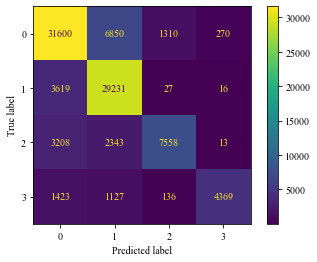

In [38]:
#Compute the confusion matrix for the random forest model's 
#predictions
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusion_mat = confusion_matrix(Predictions_Mass, Bhad_Mass_Labels)
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

In [39]:
#Convert the predictions of the MassClassifier Forest into a onehot embedding
bhadron_masses_predictions = []
for mass in Predictions_Mass:
    bhadron_masses_predictions.append([str(mass)])
print(np.shape(bhadron_masses_predictions))
encoder = OneHotEncoder(sparse = False)
predictions = encoder.fit_transform(bhadron_masses_predictions)
predictions = np.array(predictions)
print(np.shape(predictions))

(93100, 1)
(93100, 4)


In [ ]:
print(onehot.shape)

In [40]:
#Evaulates the performance of the model's predictions across the different models.
from sklearn.metrics import classification_report
target_names = ["Mass_0", "Mass_1", "Mass_2", "Mass_3"]
print(classification_report(onehot, predictions, target_names=target_names))

              precision    recall  f1-score   support

      Mass_0       0.79      0.79      0.79     39850
      Mass_1       0.89      0.74      0.81     39551
      Mass_2       0.58      0.84      0.68      9031
      Mass_3       0.62      0.94      0.75      4668

   micro avg       0.78      0.78      0.78     93100
   macro avg       0.72      0.83      0.76     93100
weighted avg       0.80      0.78      0.79     93100
 samples avg       0.78      0.78      0.78     93100



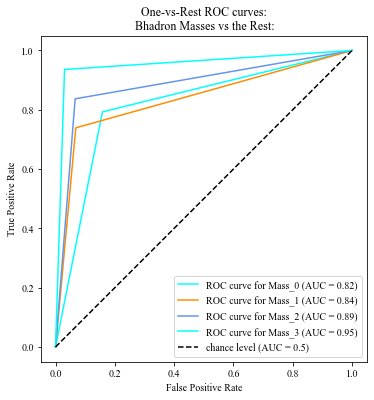

In [41]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
target_names = ["Mass_0", "Mass_1", "Mass_2", "Mass_3", "Mass_4", "Mass_5"]
fig, ax = plt.subplots(figsize = (6,6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, colors in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        onehot[:,class_id],
        predictions[:, class_id],
        name = f"ROC curve for {target_names[class_id]}",
        color = colors,
        ax = ax,
    )
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n Bhadron Masses vs the Rest:")
plt.legend()
plt.show()

In [ ]:
# Importing the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
 
 
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize']=14,6
fig = plt.figure()
 
random_seed = 1000
cov_val = Predictions_Covariance[0,:2]
vari = Predictions_Variance[:,:2]
print(vari[0,0])
cov_matrix = np.array([[vari[0,0],cov_val[0]],[cov_val[1], vari[0,1]]])
print(cov_matrix)
mean = Predictions_X[0,:2]
# Storing density function values for
# further analysis
pdf_list = []
 
# Iterating over different covariance values
for idx, val in enumerate(cov_val):
    print(val.shape)
    # Initializing the covariance matrix
    cov = np.array([[vari[0,0], val], [val, vari[0,1]]])
    print(cov.shape)
    # Generating a Gaussian bivariate distribution
    # with given mean and covariance matrix
    distr = multivariate_normal(cov = cov, mean = mean,
                                seed = random_seed)
     
    # Generating a meshgrid complacent with
    # the 3-sigma boundary
    mean_1, mean_2 = mean[0], mean[1]
    sigma_1, sigma_2 = cov[0,0], cov[1,1]
     
    x = np.linspace(-3*sigma_1, 3*sigma_1, num=100)
    y = np.linspace(-3*sigma_2, 3*sigma_2, num=100)
    X, Y = np.meshgrid(x,y)
     
    # Generating the density function
    # for each point in the meshgrid
    pdf = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])
     
    # Plotting the density function values
    key = 131+idx
    ax = fig.add_subplot(key, projection = '3d')
    ax.plot_surface(X, Y, pdf, cmap = 'viridis')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f'Covariance between x1 and x2 = {val}')
    pdf_list.append(pdf)
    ax.axes.zaxis.set_ticks([])
 
plt.tight_layout()
plt.show()
 
# Plotting contour plots
for idx, val in enumerate(pdf_list):
    plt.subplot(1,3,idx+1)
    plt.contourf(X, Y, val, cmap='viridis')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f'Covariance between x1 and x2 = {cov_val[idx]}')
plt.tight_layout()
plt.show()
     

In [ ]:
multivariate_normal(mean*1e6, cov_matrix*1e6)

In [ ]:
print(mean*1e6)
print(cov_matrix*1e6)

In [ ]:
binneddensity(Predictions_Variance[:,7], fixedbinning(0,100,100), xlabel = " bhadron X momentum fraction Uncertainty")

In [ ]:
from sklearn.model_selection import train_test_split
X_1= np.ma.masked_equal(tracks[:,:,0],-999)
print(X_1.mask)
print(np.shape(X_1),np.shape(bhads[:,0]))
X_train_ml,X_valid_ml,y_train_ml,y_valid_ml = train_test_split(X_1,bhads[:,0],random_state = 42)
print(np.shape(X_train_ml),np.shape(y_train_ml))

In [ ]:
ForestRegressor = RandomForestRegressor(n_estimators = 200, max_depth = 14, random_state = 42)
ForestRegressor.fit(X_train_ml,y_train_ml)

In [ ]:
ForestRegressor.score(X_valid_ml,y_valid_ml)

In [ ]:
Predictions = ForestRegressor.predict(X_valid_ml)
mean = np.mean(Predictions)
std = np.std(Predictions)
Pull_RandomForest = (Predictions - y_valid_ml)/std
mean2 = np.mean(Pull_RandomForest)
std2 = np.std(Pull_RandomForest)
print(mean,std)
print(mean2,std2)

In [ ]:
from sklearn.metrics import mean_absolute_error
predictions = ForestRegressor.predict(X_valid_ml)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions,y_valid_ml)))

In [ ]:
binneddensity(Predictions - y_valid_ml, fixedbinning(-100000,100000,100), xlabel ="RandomForestModel Error")

In [ ]:
binneddensity(Pull_RandomForest, fixedbinning(-1,1,100), xlabel ="RandomForestModel Pull")

In [ ]:
binneddensity(Predictions, fixedbinning(-100000,100000,100), xlabel ="RandomForestModel")

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = y_valid_ml,
    y = Predictions,
    color = "green"
)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlim([np.min(y_valid_ml),np.max(y_valid_ml)])
ax.set_ylim([np.min(Predictions),np.max(Predictions)])
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")
plt.show()

In [ ]:
xgbooster = XGBRegressor(n_estimators = 6000, num_parallel_tree = 1,early_stopping_rounds= 5, learning_rate = 1e-3)
xgbooster.fit(X_train_ml,y_train_ml, eval_set = [(X_valid_ml,y_valid_ml)], verbose = False)

In [ ]:
from sklearn.metrics import mean_absolute_error
predictions = xgbooster.predict(X_valid_ml)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions,y_valid_ml)))

In [ ]:
predictions[:10]

In [ ]:
Predictions = xgbooster.predict(X_valid_ml)
mean = np.mean(Predictions)
std = np.std(Predictions)
Pull_xgbooster = (Predictions - y_valid_ml)/std
mean2 = np.mean(Pull_xgbooster)
std2 = np.std(Pull_xgbooster)
print(mean,std)
print(mean2,std2)

In [ ]:
binneddensity(Predictions - y_valid_ml, fixedbinning(-100000,100000,100), xlabel ="XgBooster Error")

In [ ]:
binneddensity(Pull_xgbooster, fixedbinning(-1,1,100), xlabel ="Xgbooster Pull")

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = y_valid_ml,
    y = Predictions,
    color = "purple"
)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlim([np.min(y_valid_ml),np.max(y_valid_ml)])
ax.set_ylim([np.min(Predictions),np.max(Predictions)])
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")
plt.show()